In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('rowing_data.csv', index_col=0)

In [3]:
df.head()

,standing,name,age,location,country,org,time,verified,profile_link,event,weight_class,gender
0,1,Giuseppe Vinciguerra,25,NaN,ITA,ROWING TEAM CATANIA,479,Race,228928/race,1,H,M
1,2,Giovanni Sanza',36,NaN,ITA,Rowing Team Catania,439,Race,228929/race,1,H,M
2,3,Nicholas Thomas,44,"Athens , AL",USA,NaN,428,Yes,65791852/individual/1293584,1,H,M
3,4,Salvatore Mammana,33,NaN,ITA,Rowing Team Catania,415,Race,228930/race,1,H,M
4,5,Andreas Tilelis,36,Volos,GRE,NaN,413,Yes,67242240/individual/1227426,1,H,M


In [4]:
df.groupby('event').agg({'standing': 'count'})

,standing
event,
1,950
4,650
30,7300
60,2250
100,2250
500,4150
1000,4000
2000,8400
5000,10350


In [5]:
# watts = 2.80/pace^3
df['dummy_time_col'] = pd.to_timedelta(('0:' + df['time']).str.replace(r'0:(?=\d+:\d+:\d+\.\d+)', ''),
                                       errors='coerce').fillna(pd.Timedelta(seconds=1)).dt.total_seconds()

In [6]:
df['pace'] = (df['event'].isin([1, 4, 30, 60]) * (500 * 60 * df['event'] / df['time'].str.replace(r':', '').astype(float))
           + ~df['event'].isin([1, 4, 30, 60]) * (500 * df['dummy_time_col'] / df['event']))

In [7]:
df['watts'] = 2.80 / ((df['pace'] / 500) ** 3)

In [8]:
df = df[df['verified'] != 'Race']

In [9]:
df['profile_id'] = df['profile_link'].str.replace(r'\d+?/individual/', '')

In [10]:
df['profile_id'].nunique()

23475

In [11]:
df['weight-gender'] = df['weight_class'] + '-' + df['gender']

In [12]:
def valid_events(srs):
    return pd.Series([1, 60, 5000, 2000]).isin(srs).all()

valid_profile_links = df.groupby('profile_id').agg({'event': valid_events})

In [13]:
valid_profile_links.reset_index(inplace=True)

In [14]:
valid_profile_links['event'].value_counts()

False    23367
True       108
Name: event, dtype: int64

In [15]:
scale = df[df['event'] == 2000][['profile_id', 'watts']]
scale.columns = ['profile_id', 'scale']
df = pd.merge(df, scale, on='profile_id')
df['watts_scaled'] = df['watts'] / df['scale']

In [16]:
import numpy as np

cleaned_df = df[df['profile_id'].isin(valid_profile_links[valid_profile_links['event']]['profile_id'])]

In [18]:
def quant_75(srs):
    return np.quantile(srs, 0.75)

quantiles = df.groupby(['event', 'weight-gender'], as_index=False).agg({'watts_scaled': quant_75})
quantiles.columns = ['event', 'weight-gender', 'q75_watts']
df_q = pd.merge(df, quantiles, on=['event', 'weight-gender'])
valid_profiles = (df_q[(df_q['q75_watts'] < df_q['watts_scaled'])
                      & (df_q['event'].isin([30, 500]))].groupby('profile_id', as_index=False)
                                                        .agg({'watts_scaled': 'count'}))
cleaned_df = df_q[df_q['profile_id'].isin(valid_profiles[valid_profiles['watts_scaled'] > 1]['profile_id'])]

In [19]:
cleaned_df

,standing,name,age,location,country,org,time,verified,profile_link,event,weight_class,gender,dummy_time_col,pace,watts,profile_id,weight-gender,scale,watts_scaled,q75_watts
35,62,Jan-Hendrik Swiegers,41,NaN,RSA,NaN,369,Yes,69761638/individual/1675562,1,H,M,1.0,81.300813,651.303450,1675562,H-M,267.310537,2.436505,1.980983
84,237,Evan Betzer,54,"Houston, TX",USA,Ever Green Boat Club,344,Yes,63848277/individual/1362770,1,H,M,1.0,87.209302,527.690904,1362770,H-M,272.320161,1.937759,1.980983
130,343,Martin Müller,36,NaN,DEN,NaN,336,Yes,63575265/individual/1338736,1,H,M,1.0,89.285714,491.724800,1338736,H-M,278.420925,1.766120,1.980983
145,370,Carlos BALANA CAP MARARA TAHITI,63,SAINT AVERTIN,FRA,NaN,334,Yes,70110922/individual/1103476,1,H,M,1.0,89.820359,482.996163,1103476,H-M,188.313929,2.564846,1.980983
202,504,Alex Meurer,52,Deggendorf,GER,NaN,325,Yes,69941018/individual/1555292,1,H,M,1.0,92.307692,444.994213,1555292,H-M,218.669838,2.035005,1.980983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24840,39,Samantha Houston,44,Chichester,GBR,NaN,27:22.9,Yes,64051007/individual/1365466,6000,L,F,1642.9,136.908333,136.388701,1365466,L-F,128.788926,1.059010,0.907143
24845,150,sara williams,58,"Cape Canaveral, FL",USA,NaN,32:36.1,Yes,64454153/individual/1481336,6000,L,F,1956.1,163.008333,80.805072,1481336,L-F,78.340664,1.031458,0.907143
24847,37,Amanda Kammier Brockermeyer,42,"Los Angeles, CA",USA,NaN,27:17.5,No,67421026/individual/1435729,6000,L,F,1637.5,136.458333,137.742467,1435729,L-F,150.544974,0.914959,0.907143
24911,167,Kyle Darling,45,Gardner,USA,NaN,3:10:32.5,Yes,63782882/individual/1560458,42195,H,M,11432.5,135.472212,140.772355,1560458,H-M,167.677767,0.839541,0.593416


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

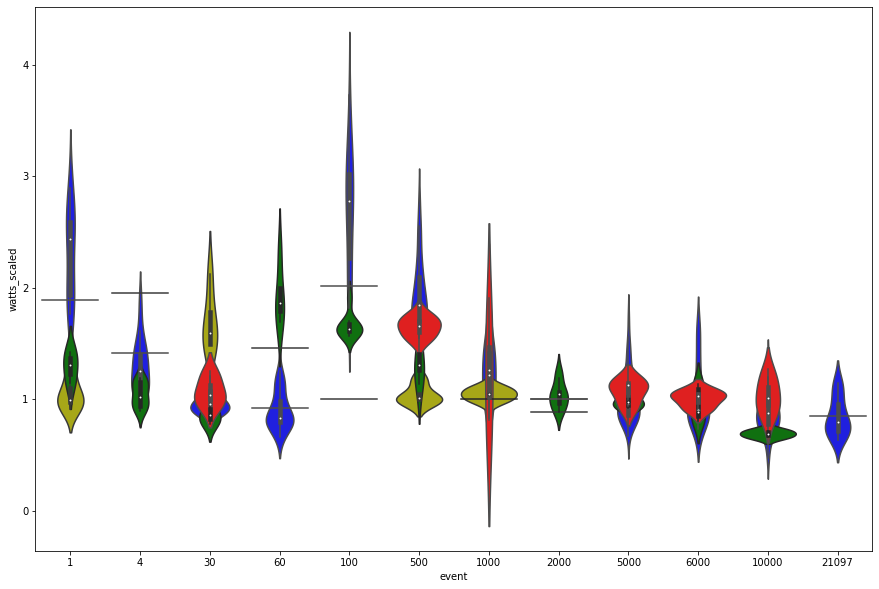

In [23]:
cmap = {'H-M': 'b', 'L-M': 'g', 'H-F': 'y', 'L-F': 'r'}
plt.figure(figsize=(15, 10))

for wg in cleaned_df['weight-gender'].unique():
    subset = cleaned_df[cleaned_df['weight-gender'] == wg]
    #plt.scatter(subset['event'], subset['watts'], c=cmap[wg])

    sns.violinplot(x='event', y='watts_scaled', data=subset, color=cmap[wg])

Text(0, 0.5, 'watts ratio')

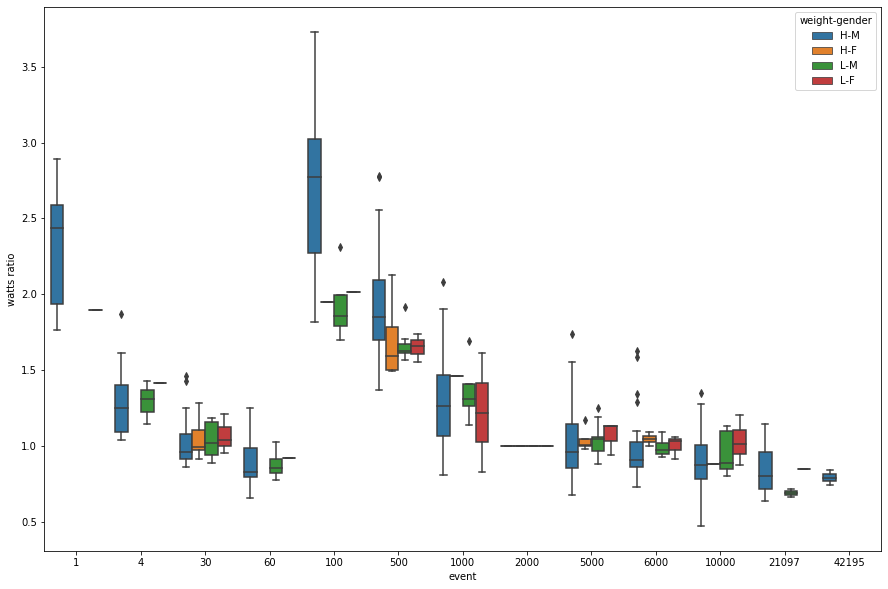

In [24]:
import seaborn as sns
plt.figure(figsize=(15, 10))

sns.boxplot(x='event', y='watts_scaled', data=cleaned_df, hue='weight-gender')
plt.ylabel('watts ratio')

In [25]:
df

,standing,name,age,location,country,org,time,verified,profile_link,event,weight_class,gender,dummy_time_col,pace,watts,profile_id,weight-gender,scale,watts_scaled
0,5,Keaton Rutherford,32,"Sydney, NSW",AUS,GARAGEATHLETE,413,Yes,64447313/individual/1352048,1,H,M,1.0,72.639225,913.175887,1352048,H-M,330.784760,2.760635
1,6,Keaton Rutherford,32,"Sydney, NSW",AUS,GARAGEATHLETE,0:13.4,Yes,63953580/individual/1352048,100,H,M,13.4,67.000000,1163.706972,1352048,H-M,330.784760,3.518019
2,62,Keaton Rutherford,32,"Sydney, NSW",AUS,GARAGEATHLETE,1:22.4,Yes,64177150/individual/1352048,500,H,M,82.4,82.400000,625.585119,1352048,H-M,330.784760,1.891215
3,355,Keaton Rutherford,32,"Sydney, NSW",AUS,GARAGEATHLETE,6:47.6,Yes,64468554/individual/1352048,2000,H,M,407.6,101.900000,330.784760,1352048,H-M,330.784760,1.000000
4,22,Paweł Fus,44,Ożarów Mazowiecki,POL,FusGym Rowing Team,384,Yes,64299728/individual/1387785,1,H,M,1.0,78.125000,734.003200,1387785,H-M,320.766490,2.288279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25036,394,Jo Kong,40,NaN,CAN,NaN,12:41.9,No,70014110/individual/1778823,2000,L,F,761.9,190.475000,50.647043,1778823,L-F,50.647043,1.000000
25037,396,andrea lawson,49,NaN,CAN,NaN,12:48.1,No,64396866/individual/1624513,2000,L,F,768.1,192.025000,49.430468,1624513,L-F,49.430468,1.000000
25038,397,Judy Driggans,66,TN,USA,TEAM MELALEUCA,12:52.2,No,68842389/individual/1488068,2000,L,F,772.2,193.050000,48.647287,1488068,L-F,48.647287,1.000000
25039,398,Claire Rennison,38,NaN,GBR,NaN,12:54.6,No,65494361/individual/1310620,2000,L,F,774.6,193.650000,48.196504,1310620,L-F,48.196504,1.000000
